# Учебный кейс «Модель прогнозирования стоимости жилья для агентства недвижимости»

Задача: агентство недвижимости столкнулось с проблемой — риелторы тратят слишком много времени на сортировку объявлений и поиск выгодных предложений. Поэтому скорость их реакции и качество анализа не дотягивают до уровня конкурентов. Это сказывается на финансовых показателях агентства.

Цель — разработать модель машинного обучения, которая поможет обрабатывать объявления и увеличит число сделок и прибыль агентства.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import category_encoders as ce
from sklearn import preprocessing
from sklearn import model_selection
from ast import literal_eval as le
from comet_ml import Experiment

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (1.26.12) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn(


# Подготовка данных

In [2]:
# Сброс ограничений на число столбцов
pd.set_option('display.max_columns', None)

data = pd.read_csv('data/data-2.csv')
data.head()

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
0,Active,NaN,Single Family Home,240 Heather Ln,3.5,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",Gas Logs,Southern Pines,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,28387,4,NC,NaN,NaN,NaN,611019,"$418,000"
1,for sale,NaN,single-family home,12911 E Heroy Ave,3 Baths,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Spokane Valley,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...","1,947 sqft",99216,3 Beds,WA,2.0,NaN,NaN,201916904,"$310,000"
2,for sale,NaN,single-family home,2005 Westridge Rd,2 Baths,"{'atAGlanceFacts': [{'factValue': '1961', 'fac...",yes,Los Angeles,"[{'rating': ['8/10', '4/10', '8/10'], 'data': ...","3,000 sqft",90049,3 Beds,CA,1.0,NaN,yes,FR19221027,"$2,895,000"
3,for sale,NaN,single-family home,4311 Livingston Ave,8 Baths,"{'atAGlanceFacts': [{'factValue': '2006', 'fac...",yes,Dallas,"[{'rating': ['9/10', '9/10', '10/10', '9/10'],...","6,457 sqft",75205,5 Beds,TX,3.0,NaN,NaN,14191809,"$2,395,000"
4,for sale,NaN,lot/land,1524 Kiscoe St,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Palm Bay,"[{'rating': ['4/10', '5/10', '5/10'], 'data': ...",NaN,32908,NaN,FL,NaN,NaN,NaN,861745,"$5,000"


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377185 entries, 0 to 377184
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   status        337267 non-null  object
 1   private pool  4181 non-null    object
 2   propertyType  342452 non-null  object
 3   street        377183 non-null  object
 4   baths         270847 non-null  object
 5   homeFacts     377185 non-null  object
 6   fireplace     103115 non-null  object
 7   city          377151 non-null  object
 8   schools       377185 non-null  object
 9   sqft          336608 non-null  object
 10  zipcode       377185 non-null  object
 11  beds          285903 non-null  object
 12  state         377185 non-null  object
 13  stories       226470 non-null  object
 14  mls-id        24942 non-null   object
 15  PrivatePool   40311 non-null   object
 16  MlsId         310305 non-null  object
 17  target        374704 non-null  object
dtypes: object(18)
memory usa

## Пропуски и обработка данных

In [4]:
# ПРОПУСКИ
# смотрим, в каких столбцах есть пропуски и какой процент этих пропусков
cols_null_percent = data.isnull().mean() * 100
cols_with_null = cols_null_percent[cols_null_percent>0].sort_values(ascending=False)
display(cols_with_null)

private pool    98.891525
mls-id          93.387330
PrivatePool     89.312672
fireplace       72.661956
stories         39.957846
baths           28.192532
beds            24.200856
MlsId           17.731352
sqft            10.757851
status          10.583136
propertyType     9.208479
target           0.657767
city             0.009014
street           0.000530
dtype: float64

In [5]:
# Так как в столбцах private pool, mls-id, PrivatePool, fireplace очень много пропусков (блолее 70%), эти столбцв придется удалить.
#создаем копию исходной таблицы
drop_data = data.copy()
#задаем минимальный порог: вычисляем 60% от числа строк
thresh = drop_data.shape[0]*0.6
#удаляем столбцы, в которых более 40% (100-60) пропусков
drop_data = drop_data.dropna(thresh=thresh, axis=1)

print(drop_data.shape)

(377185, 14)


### Признак baths

In [6]:
# для заполнения пропусков в столбце "baths" обработаем значения
def bath(s):
    s=str(s)
    if s.startswith('Bathrooms: '):
        return s[11:]
    if s.lower().endswith(' baths') :
        return s[:-6]
    if s.lower().endswith(' ba') :
        return s[:-3]
    if s.count('.')>0:
        i = s.find('.')
        return s[:i]
    if s.count(',')>0:
        i = s.find(',')
        return s[:i]
    if s.count('-')>0:
        i = s.find('-')
        return s[:i]
    if s.count('/')>0:
        i = s.find('/')
        return s[:i-1]
    if not s.isdigit():
        s=np.nan
    return s
    
drop_data['baths'] = drop_data['baths'].apply(bath)
drop_data['baths'] = drop_data['baths'].apply(bath)

#модой заполнять

### Признак beds

In [17]:
# по тому же принципу обработаем столбец "beds"
def beds(s):
    s=str(s)
    if s.lower().endswith(' beds'):
        s= s[:-5]
    if s.lower().endswith('sqft') or  s.lower().endswith('acres'):
        s=''
    if s.lower().endswith(' bd'):
        s= s[:-3]
    if s.count(' or More Bedrooms'):
        i = s.find(' or More Bedrooms')
        s= s[:i-1]
    if s.count('Bedrooms'):
        i = s.find('Bedrooms')
        s= s[:i-1]
    if not s.isdigit():
        s=np.nan
    return s
# сохраним данные перед обработкой, может из них что-то полезное вытащим ещё
drop_data['copy_beds'] = drop_data['beds']    
drop_data['beds'] = drop_data['beds'].apply(beds)

### Признак sqft

In [68]:
# обрабатываем столбец sqft
def sqft(s):
    s=str(s)
    if s.lower().endswith(' sqft'):
        s= s[:-5]
    if s.startswith('Total interior livable area: '):
        s= s[29:]
    if s.count(','):
        s= s.replace(',','')
    if not s.isdigit():
        s=np.nan
    return s
    
drop_data['sqft'] = drop_data['sqft'].apply(sqft)    
drop_data['sqft'] = drop_data['sqft'].apply(sqft)    
 

In [19]:
# найдем в столбце copy_beds значения со словом sqft и запишем в столбец sqft
for i in range(drop_data.shape[0]):
    if str(drop_data.iloc[i]['copy_beds']).endswith('sqft'):
        drop_data.iloc[i]['sqft']=str(drop_data.iloc[i]['copy_beds']).replace(',','')[:-5]
    

/var/folders/tp/mcxy8wd524b65_m2_4n493dh0000gn/T/ipykernel_53163/145455059.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  drop_data.iloc[i]['sqft']=str(drop_data.iloc[i]['copy_beds']).replace(',','')[:-5]


In [20]:
# найдем в столбце copy_beds значения со словом acres и запишем в столбец sqft это значение*43560 (соотношение акра к квадратному футу)
for i in range(drop_data.shape[0]):
    if str(drop_data.iloc[i]['copy_beds']).endswith('acres'):
        drop_data.iloc[i]['sqft']=float(str(drop_data.iloc[i]['copy_beds']).replace('.','')[:-6])*43560
    

/var/folders/tp/mcxy8wd524b65_m2_4n493dh0000gn/T/ipykernel_53163/2713470687.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  drop_data.iloc[i]['sqft']=float(str(drop_data.iloc[i]['copy_beds']).replace('.','')[:-6])*43560


In [21]:
# удаляем вспомогательный столбец
drop_data = drop_data.drop('copy_beds',axis=1)
drop_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377185 entries, 0 to 377184
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   status        337267 non-null  object
 1   propertyType  342452 non-null  object
 2   street        377183 non-null  object
 3   baths         269856 non-null  object
 4   homeFacts     377185 non-null  object
 5   city          377151 non-null  object
 6   schools       377185 non-null  object
 7   sqft          335787 non-null  object
 8   zipcode       377185 non-null  object
 9   beds          247108 non-null  object
 10  state         377185 non-null  object
 11  stories       226470 non-null  object
 12  MlsId         310305 non-null  object
 13  target        374704 non-null  object
dtypes: object(14)
memory usage: 40.3+ MB


### Признак stories

In [44]:
# для заполнения пропусков в столбце "stories" обработаем значения
def stories(s):
    s=str(s)
    s=s.lower()
    # if s.count('level'):
    #     s= s[:s.lower().find('level')]
    if s.endswith('story'):
        s= s[:s.lower().find('story')]
    if s.count('one') or s.count('1') or s.count('ground') or s=='f' or s.count('farm house'):
        s= '1'
    if s.count('two') or s.count('2'):
        s= '2'
    if s.count('tri') or s.count('three') or s.count('3'):
        s= '3'
    if s.count('.'):
        i = s.find('.')
        s= s[:i]
    if s.count("+"):
        i = s.find('+')
        s= s[:i]
    if s.count('multi'):
        s = '9'
    if s.count('high'):
        s = '16'
    if s.lower().count('nan'):
        return np.nan
    if not s.isdigit():
        s=np.nan
    return s
    
drop_data['stories'] = drop_data['stories'].apply(stories)


### Признак status

In [45]:
# обработка столбца status

def status(s):
    s=str(s)
    s = s.replace('   ',' ')
    s = s.replace('  ',' ')
    s = s.lower()
    if s.count('coming soon'):
        return 'coming soon'
    if s.count('foreclosure'):
        return 'pre foreclosure'
    if s.count('under contract backups') or s.count('active backup') or s.count('backup contract'):
        return 'under contract backups'
    if s.count('under contract show') or s.count('under contract') or s.count('active under contract'):
        return 'under contract show'
    if s.count('auction'):
        return 'active auction'

    # elif not s.isdigit():
    #     s=''
    return s
    
drop_data['status'] = drop_data['status'].apply(status)


### Признак target

In [46]:
def target(s):
    s=str(s)
    s = s.replace(',','')
    if s.startswith('$'):
        return s[1:]
    if s.count('+'):
        return s.replace('+','')
    if not s.isdigit():
        s=np.nan
    return s

drop_data['target'] = drop_data['target'].apply(target)
drop_data['target'] = drop_data['target'].apply(target)

### Признак homeFacts

In [47]:
# так же вытащим данные из столбца homeFacts
# сначала создаём новые пустые столбцы
r = le(drop_data['homeFacts'][0])
for i in range (len(r['atAGlanceFacts'])):
    el = r['atAGlanceFacts'][i]
    drop_data[el['factLabel']] = np.nan

In [48]:
# из столбца homeFacts разобьём данные в отдельные столбцы
# цикл по строкам датафрейма, строковое значение из homeFacts преобразуем в словарь
# затем идем по списку словарей из словаря под ключом 'atAGlanceFacts' 
# и записываем значения 'factValue' в каждый столбец с названием 'factLabel'

for i in range(drop_data.shape[0]):
    result = le(drop_data['homeFacts'][i])['atAGlanceFacts']
    for j in range(len(result)):
        drop_data[result[j]['factLabel']].iloc[i] = result[j]['factValue']
        
display(drop_data.head(5))

/var/folders/tp/mcxy8wd524b65_m2_4n493dh0000gn/T/ipykernel_53163/3039786424.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  drop_data[result[j]['factLabel']].iloc[i] = result[j]['factValue']


,status,propertyType,street,baths,homeFacts,city,schools,sqft,zipcode,beds,state,stories,MlsId,target,Year built,Remodeled year,Heating,Cooling,Parking,lotsize,Price/sqft
0,active,Single Family Home,240 Heather Ln,3,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",Southern Pines,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,28387,4,NC,NaN,611019,418000,2019,,"Central A/C, Heat Pump",,,NaN,$144
1,for sale,single-family home,12911 E Heroy Ave,3,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",Spokane Valley,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...",1947,99216,3,WA,2,201916904,310000,2019,,,,,5828 sqft,$159/sqft
2,for sale,single-family home,2005 Westridge Rd,2,"{'atAGlanceFacts': [{'factValue': '1961', 'fac...",Los Angeles,"[{'rating': ['8/10', '4/10', '8/10'], 'data': ...",3000,90049,3,CA,1,FR19221027,2895000,1961,1967,Forced Air,Central,Attached Garage,"8,626 sqft",$965/sqft
3,for sale,single-family home,4311 Livingston Ave,8,"{'atAGlanceFacts': [{'factValue': '2006', 'fac...",Dallas,"[{'rating': ['9/10', '9/10', '10/10', '9/10'],...",6457,75205,5,TX,3,14191809,2395000,2006,2006,Forced Air,Central,Detached Garage,"8,220 sqft",$371/sqft
4,for sale,lot/land,1524 Kiscoe St,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",Palm Bay,"[{'rating': ['4/10', '5/10', '5/10'], 'data': ...",NaN,32908,NaN,FL,NaN,861745,5000,,,,,,"10,019 sqft",None


In [49]:
# теперь можно удалить столбец homeFacts
drop_data = drop_data.drop('homeFacts',axis=1)
drop_data.head()

,status,propertyType,street,baths,city,schools,sqft,zipcode,beds,state,stories,MlsId,target,Year built,Remodeled year,Heating,Cooling,Parking,lotsize,Price/sqft
0,active,Single Family Home,240 Heather Ln,3,Southern Pines,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,28387,4,NC,NaN,611019,418000,2019,,"Central A/C, Heat Pump",,,NaN,$144
1,for sale,single-family home,12911 E Heroy Ave,3,Spokane Valley,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...",1947,99216,3,WA,2,201916904,310000,2019,,,,,5828 sqft,$159/sqft
2,for sale,single-family home,2005 Westridge Rd,2,Los Angeles,"[{'rating': ['8/10', '4/10', '8/10'], 'data': ...",3000,90049,3,CA,1,FR19221027,2895000,1961,1967,Forced Air,Central,Attached Garage,"8,626 sqft",$965/sqft
3,for sale,single-family home,4311 Livingston Ave,8,Dallas,"[{'rating': ['9/10', '9/10', '10/10', '9/10'],...",6457,75205,5,TX,3,14191809,2395000,2006,2006,Forced Air,Central,Detached Garage,"8,220 sqft",$371/sqft
4,for sale,lot/land,1524 Kiscoe St,NaN,Palm Bay,"[{'rating': ['4/10', '5/10', '5/10'], 'data': ...",NaN,32908,NaN,FL,NaN,861745,5000,,,,,,"10,019 sqft",None


In [50]:
# заменяем пропусками пустые значения
def my_nan(s):
    if s=='' or s==' ' or s=='   ':
        return np.nan
    return s

drop_data['Year built'] = drop_data['Year built'].apply(my_nan)
drop_data['Remodeled year'] = drop_data['Remodeled year'].apply(my_nan)
drop_data['Heating'] = drop_data['Heating'].apply(my_nan)
drop_data['Cooling'] = drop_data['Cooling'].apply(my_nan)
drop_data['Parking'] = drop_data['Parking'].apply(my_nan)
drop_data['lotsize'] = drop_data['lotsize'].apply(my_nan)
drop_data['Price/sqft'] = drop_data['Price/sqft'].apply(my_nan)

In [51]:
# обработка столбца Price/sqft
def price(s):
    s = str(s)
    if s.startswith('$'):
        s=s[1:]
    if s.count('/'):
        i = s.find('/')
        s=s[:i]
    if s.count(','):
        s=s.replace(',','')
    s = s.strip(' ')
    if not s.isdigit():
         s=np.nan
    return s

drop_data['Price/sqft'] = drop_data['Price/sqft'].apply(price)

In [52]:
# обработка столбца lotsize

def lotsize(s):
    s = str(s)
    s = s.lower()
    if s.endswith('sqft'):
        s=s[:-5]
    if s.endswith('sqft lot'):
        s=s[:-9]
    if s.endswith('acres'):
        s=s[:-6]
    if s.endswith('sq ft'):
        s=s[:-6]
    if s.count('.'):
        s=s.replace('.','')
    if s.count(','):
        s=s.replace(',','')
    s = s.strip(' ')
    if not s.isdigit():
         s=np.nan
    return s

drop_data['lotsize'] = drop_data['lotsize'].apply(lotsize)
drop_data['lotsize'] = drop_data['lotsize'].apply(lotsize)


In [53]:
drop_data['Year built'] = drop_data['Year built'].apply(lambda x: np.nan if x=='No Data'  else x)

### Признак propertyType

In [54]:
def propertyType(s):
    s=str(s)
    s=s.lower()
    if s.count('single') or s.count('detached') or s.count('tiny home'):
        return 'single-family'
    if s.count('multi'):
        return 'multi-family'
    if s.count('townhome') or s.count('townhouse'):
        return 'townhome'
    if s.count('midcentury') or s.count('mid century') or s.count('mid-century'):
        return 'midcentury modern'
    if s.count('log'):
        return 'log'
    if s.count('ranch'):
        return 'ranch'
    if s.count('split'):
        return 'split'
    if s.count('traditional'):
        return 'traditional'
    if s.count('other'):
        return 'other'
    if s.count('cape'):
        return 'cape cod'
    if s.count('mediterranean'):
        return 'mediterranean'
    if s.count('apart'):
        return 'apartment'
    if s.count('contemporary'):
        return 'contemporary'
    if s.count('garden home'):
        return 'garden home'
    if s.count('tudor'):
        return 'tudor'
    if s.count('bungalow'):
        return 'bungalow'
    if s.count('colonial'):
        return 'colonial'
    if s.count('coop') or s.count('co-op'):
        return 'cooperative'
    if s.count('cabin') or s.count('ca2 n') or s.count('ca2n'):
        return 'cabin'
    if s.count('manufactured') or s.count('mobile') or s.count('prefab') or s.count('modular') or s.count('mo2 le') or s.count('mo2le'):
        return 'manufactured'
    if s.count('custom'):
        return 'custom'
    if s.count('histo') or s.count('old'):
        return 'historic'
    if s.count('craftsman'):
        return 'craftsman'
    if s.count('condo'):
        return 'condo'
    if s=='' or s==' ' or s=='nan':
        return 'unknown'
    if s.count('spanish') or s.count('french') or s.count('english') or s.count('european'):
        return 'european'
    if s.count('land'):
        return 'land'
    if s.count('florida') or s.count('key west') or s.count('texas'):
        return 'key west'
    if s.count('transitional'):
        return 'transitional'
    if s.count('modern'):
        return 'modern'
    if s.count('victorian') or s.count('queen'):
        return 'victorian'
    if s.count('art'):
        return 'art deco'
    if s.count('loft'):
        return 'loft'
    if s.count('attached'):
        return "attached"
    if s.count('carriage'):
        return 'carriage'
    if s.count('federal'):
        return 'federal'
    if s.count('cottage'):
        return 'cottage'
    if s.count('low') or s.count('1') or s.count('2') or s.count('bilevel') or s.count('bi-level') or s.count('3') or s.count('two') or s.count('one') or s.count('three') or s.count('tri') or s.count('less than 4'):
        return 'low rise'
    if s.count('high') or s.count('hi-rise'):
        return 'high rise'
    if s.count('mid-rise') or s.count('4+') or s.count('5-9') or s.count('mid-level') or s.count('mid rise'):
        return 'mid-rise'
        
    return s

drop_data['propertyType'] = drop_data['propertyType'].apply(propertyType)

In [55]:
drop_data.head()

,status,propertyType,street,baths,city,schools,sqft,zipcode,beds,state,stories,MlsId,target,Year built,Remodeled year,Heating,Cooling,Parking,lotsize,Price/sqft
0,active,single-family,240 Heather Ln,3,Southern Pines,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,28387,4,NC,NaN,611019,418000,2019,NaN,"Central A/C, Heat Pump",NaN,NaN,NaN,144
1,for sale,single-family,12911 E Heroy Ave,3,Spokane Valley,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...",1947,99216,3,WA,2,201916904,310000,2019,NaN,NaN,NaN,NaN,5828,159
2,for sale,single-family,2005 Westridge Rd,2,Los Angeles,"[{'rating': ['8/10', '4/10', '8/10'], 'data': ...",3000,90049,3,CA,1,FR19221027,2895000,1961,1967,Forced Air,Central,Attached Garage,8626,965
3,for sale,single-family,4311 Livingston Ave,8,Dallas,"[{'rating': ['9/10', '9/10', '10/10', '9/10'],...",6457,75205,5,TX,3,14191809,2395000,2006,2006,Forced Air,Central,Detached Garage,8220,371
4,for sale,land,1524 Kiscoe St,NaN,Palm Bay,"[{'rating': ['4/10', '5/10', '5/10'], 'data': ...",NaN,32908,NaN,FL,NaN,861745,5000,NaN,NaN,NaN,NaN,NaN,10019,NaN


### Признак schools

In [56]:
drop_data['schools_raiting'] = np.nan
drop_data['schools_distance'] = np.nan
drop_data['schools_grades'] = np.nan
drop_data['schools_name'] = np.nan

# из столбца schools разобьём данные в отдельные столбцы
for i in range(drop_data.shape[0]):
    result = le(drop_data['schools'][i])
    drop_data['schools_raiting'].iloc[i] = result[0]['rating']
    drop_data['schools_distance'].iloc[i] = result[0]['data']['Distance']
    drop_data['schools_grades'].iloc[i] = result[0]['data']['Grades']
    drop_data['schools_name'].iloc[i] = result[0]['name']

drop_data.head(5)

/var/folders/tp/mcxy8wd524b65_m2_4n493dh0000gn/T/ipykernel_53163/327946396.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  drop_data['schools_raiting'].iloc[i] = result[0]['rating']
/var/folders/tp/mcxy8wd524b65_m2_4n493dh0000gn/T/ipykernel_53163/327946396.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  drop_data['schools_distance'].iloc[i] = result[0]['data']['Distance']
/var/folders/tp/mcxy8wd524b65_m2_4n493dh0000gn/T/ipykernel_53163/327946396.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pand

,status,propertyType,street,baths,city,schools,sqft,zipcode,beds,state,stories,MlsId,target,Year built,Remodeled year,Heating,Cooling,Parking,lotsize,Price/sqft,schools_raiting,schools_distance,schools_grades,schools_name
0,active,single-family,240 Heather Ln,3,Southern Pines,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,28387,4,NC,NaN,611019,418000,2019,NaN,"Central A/C, Heat Pump",NaN,NaN,NaN,144,"[4, 4, 7, NR, 4, 7, NR, NR]","[2.7 mi, 3.6 mi, 5.1 mi, 4.0 mi, 10.5 mi, 12.6...","[3–5, 6–8, 9–12, PK–2, 6–8, 9–12, PK–5, K–12]","[Southern Pines Elementary School, Southern Mi..."
1,for sale,single-family,12911 E Heroy Ave,3,Spokane Valley,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...",1947,99216,3,WA,2,201916904,310000,2019,NaN,NaN,NaN,NaN,5828,159,"[4/10, None/10, 4/10]","[1.65mi, 1.32mi, 1.01mi]","[9-12, 3-8, PK-8]","[East Valley High School&Extension, Eastvalley..."
2,for sale,single-family,2005 Westridge Rd,2,Los Angeles,"[{'rating': ['8/10', '4/10', '8/10'], 'data': ...",3000,90049,3,CA,1,FR19221027,2895000,1961,1967,Forced Air,Central,Attached Garage,8626,965,"[8/10, 4/10, 8/10]","[1.19mi, 2.06mi, 2.63mi]","[6-8, K-5, 9-12]","[Paul Revere Middle School, Brentwood Science ..."
3,for sale,single-family,4311 Livingston Ave,8,Dallas,"[{'rating': ['9/10', '9/10', '10/10', '9/10'],...",6457,75205,5,TX,3,14191809,2395000,2006,2006,Forced Air,Central,Detached Garage,8220,371,"[9/10, 9/10, 10/10, 9/10]","[1.05mi, 0.1mi, 1.05mi, 0.81mi]","[5-6, PK-4, 7-8, 9-12]","[Mcculloch Intermediate School, Bradfield Elem..."
4,for sale,land,1524 Kiscoe St,NaN,Palm Bay,"[{'rating': ['4/10', '5/10', '5/10'], 'data': ...",NaN,32908,NaN,FL,NaN,861745,5000,NaN,NaN,NaN,NaN,NaN,10019,NaN,"[4/10, 5/10, 5/10]","[5.96mi, 3.25mi, 3.03mi]","[7-8, 9-12, PK-6]","[Southwest Middle School, Bayside High School,..."


In [57]:
# удаляем признак schools
drop_data = drop_data.drop('schools', axis=1)

### Признаки schools_raiting, schools_distance, schools_grades, schools_name

In [26]:
copy_df = drop_data.copy()
drop_data.shape
#(377185, 23)

(377185, 23)

In [27]:
drop_data=copy_df.copy()

In [28]:
drop_data.shape

(377185, 23)

Очень очень долго делается, пропустим пока

In [36]:
# новые признаки, получившиеся из признака schools содержат в себе списки. Разобьём эти списки путем добавления новых строк так, 
# чтобы значениями этих признаков стали не списки, а элементы списка.
len_first = drop_data.shape[0]
for i in range(100):
#for i in range(90,94):
    l = min([len(drop_data['schools_raiting'].iloc[i]),len(drop_data['schools_distance'].iloc[i]),
             len(drop_data['schools_grades'].iloc[i]),len(drop_data['schools_name'].iloc[i])])
    for j in range(l):
        drop_data.loc[len(drop_data.index )] = [drop_data['status'][i], drop_data['propertyType'][i],drop_data['street'][i],
                                                drop_data['baths'][i], drop_data['city'][i],drop_data['sqft'][i],drop_data['zipcode'][i],
                                                drop_data['beds'][i],drop_data['state'][i], drop_data['stories'][i],drop_data['MlsId'][i],
                                                drop_data['target'][i],drop_data['Year built'][i],drop_data['Remodeled year'][i],
                                                drop_data['Heating'][i],drop_data['Cooling'][i],drop_data['Parking'][i],
                                                drop_data['lotsize'][i],drop_data['Price/sqft'][i],
                                                drop_data['schools_raiting'].iloc[i][j],
                                                drop_data['schools_distance'].iloc[i][j],drop_data['schools_grades'].iloc[i][j],
                                                drop_data['schools_name'].iloc[i][j]]
        

In [58]:
# ещё раз смотрим, в каких столбцах есть пропуски и какой процент этих пропусков
cols_null_percent = drop_data.isnull().mean() * 100
cols_with_null = cols_null_percent[cols_null_percent>0].sort_values(ascending=False)
display(cols_with_null)

Remodeled year    59.946711
Parking           46.507682
stories           40.467410
lotsize           34.615374
beds              34.486260
Cooling           32.866365
Heating           28.986306
baths             28.455267
MlsId             17.731352
Price/sqft        17.481342
Year built        16.860692
sqft              10.975516
target             0.763286
city               0.009014
street             0.000530
dtype: float64

In [60]:
# удалим столбцы с большим количеством пропусков
#задаем минимальный порог: вычисляем 60% от числа строк
thresh = drop_data.shape[0]*0.6
#удаляем столбцы, в которых более 40% (100-60) пропусков
drop_data = drop_data.dropna(thresh=thresh, axis=1)

print(drop_data.shape)

(377185, 20)


In [70]:
drop_data.head()

,status,propertyType,street,baths,city,sqft,zipcode,beds,state,MlsId,target,Year built,Heating,Cooling,lotsize,Price/sqft,schools_raiting,schools_distance,schools_grades,schools_name
0,active,single-family,240 Heather Ln,3,Southern Pines,2900,28387,4,NC,611019,418000,2019,"Central A/C, Heat Pump",NaN,NaN,144,"[4, 4, 7, NR, 4, 7, NR, NR]","[2.7 mi, 3.6 mi, 5.1 mi, 4.0 mi, 10.5 mi, 12.6...","[3–5, 6–8, 9–12, PK–2, 6–8, 9–12, PK–5, K–12]","[Southern Pines Elementary School, Southern Mi..."
1,for sale,single-family,12911 E Heroy Ave,3,Spokane Valley,1947,99216,3,WA,201916904,310000,2019,NaN,NaN,5828,159,"[4/10, None/10, 4/10]","[1.65mi, 1.32mi, 1.01mi]","[9-12, 3-8, PK-8]","[East Valley High School&Extension, Eastvalley..."
2,for sale,single-family,2005 Westridge Rd,2,Los Angeles,3000,90049,3,CA,FR19221027,2895000,1961,Forced Air,Central,8626,965,"[8/10, 4/10, 8/10]","[1.19mi, 2.06mi, 2.63mi]","[6-8, K-5, 9-12]","[Paul Revere Middle School, Brentwood Science ..."
3,for sale,single-family,4311 Livingston Ave,8,Dallas,6457,75205,5,TX,14191809,2395000,2006,Forced Air,Central,8220,371,"[9/10, 9/10, 10/10, 9/10]","[1.05mi, 0.1mi, 1.05mi, 0.81mi]","[5-6, PK-4, 7-8, 9-12]","[Mcculloch Intermediate School, Bradfield Elem..."
4,for sale,land,1524 Kiscoe St,NaN,Palm Bay,NaN,32908,NaN,FL,861745,5000,NaN,NaN,NaN,10019,NaN,"[4/10, 5/10, 5/10]","[5.96mi, 3.25mi, 3.03mi]","[7-8, 9-12, PK-6]","[Southwest Middle School, Bayside High School,..."


In [71]:
# сохраним наш подготовленный на этом этапе датафрейм
drop_data.to_csv('data/drop_data.csv',index=False)

### Ещё раз пропуски

Для baseline просто удалим строки с пропусками и столбцы со списками schools_***

In [143]:
base_data = drop_data.dropna(how='any', axis=0)#удаляем записи, в которых есть хотя бы 1 пропуск
base_data = base_data.drop(['schools_raiting','schools_distance','schools_grades','schools_name'],axis=1)
base_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53741 entries, 2 to 377180
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   status          53741 non-null  object
 1   propertyType    53741 non-null  object
 2   street          53741 non-null  object
 3   baths           53741 non-null  object
 4   city            53741 non-null  object
 5   sqft            53741 non-null  object
 6   zipcode         53741 non-null  object
 7   state           53741 non-null  object
 8   stories         53741 non-null  object
 9   MlsId           53741 non-null  object
 10  target          53741 non-null  object
 11  Year built      53741 non-null  object
 12  Remodeled year  53741 non-null  object
 13  Heating         53741 non-null  object
 14  Cooling         53741 non-null  object
 15  Parking         53741 non-null  object
 16  lotsize         53741 non-null  object
 17  Price/sqft      53741 non-null  object
dtypes: ob

### Дубликаты

In [144]:
# проверяем на дубликаты
print(f'Число найденных дубликатов: {sum(base_data.duplicated())}')


Число найденных дубликатов: 17


In [145]:
# удаляем дубликаты
base_data = base_data.drop_duplicates()
base_data.shape

(53724, 18)

### Выбросы

In [160]:
# Create an experiment with your api key
experiment = Experiment(
    api_key="nhFiCphwBmDKmZBsi0LZLPe0C",
    project_name="final-project",
    workspace="masnikova-comet",
)

COMET WARNING: Comet has disabled auto-logging functionality as it has been imported after the following ML modules: sklearn. Metrics and hyperparameters can still be logged using comet_ml.log_metrics() and comet_ml.log_parameters()
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/masnikova-comet/final-project/670276578e9e4311b1e01f3288ffcb79



In [146]:
# столбы MlsId, street слишком уникальные, удалим их
base_data = base_data.drop(['MlsId', 'street'],axis=1)

In [147]:
# столбцы, которые предполагают числовой формат, переведем в числа
base_data['baths'] = base_data['baths'].astype(int)
base_data['sqft'] = base_data['sqft'].astype(int)
base_data['zipcode'] = base_data['zipcode'].astype(int)
base_data['stories'] = base_data['stories'].astype(int)
base_data['target'] = base_data['target'].astype(int)
base_data['Year built'] = base_data['Year built'].astype(int)
base_data['Remodeled year'] = base_data['Remodeled year'].astype(int)
base_data['lotsize'] = base_data['lotsize'].astype(int)
base_data['Price/sqft'] = base_data['Price/sqft'].astype(int)

In [149]:
base_data.describe()

,baths,sqft,zipcode,stories,target,Year built,Remodeled year,lotsize,Price/sqft
count,53724.000000,53724.000000,53724.000000,53724.000000,5.372400e+04,53724.000000,53724.000000,5.372400e+04,53724.000000
mean,3.027827,2588.480623,58287.433382,1.500838,7.779739e+05,1976.610937,1985.351873,4.494992e+03,246.874786
std,1.499197,3412.834552,25204.238785,1.287346,2.269933e+06,28.162998,43.765042,2.159644e+04,297.312014
min,1.000000,40.000000,2108.000000,0.000000,1.000000e+00,1794.000000,0.000000,1.000000e+00,0.000000
25%,2.000000,1550.000000,33196.000000,1.000000,2.350000e+05,1957.000000,1971.000000,7.600000e+01,125.000000
50%,3.000000,2127.500000,75048.000000,1.000000,3.699000e+05,1981.000000,1990.000000,4.896000e+03,176.000000
75%,4.000000,3029.250000,77590.000000,2.000000,6.750000e+05,2001.000000,2005.000000,7.562000e+03,266.000000
max,26.000000,683892.000000,99337.000000,57.000000,1.650000e+08,2020.000000,2020.000000,4.929944e+06,25394.000000


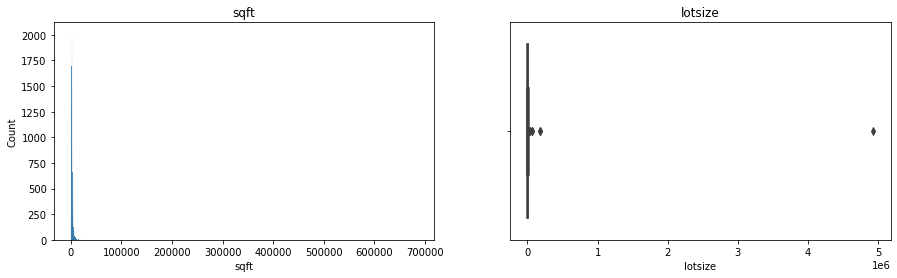

In [150]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=base_data, x='sqft', ax=axes[0]);
histplot.set_title('sqft');
boxplot = sns.boxplot(data=base_data, x='lotsize', ax=axes[1]);
boxplot.set_title('lotsize');

В признаках sqft и lotsize явно есть выбросы

In [91]:
# метод Тьюки
def outliers_iqr(data, feature):
    x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x >= lower_bound) & (x <= upper_bound)]
    return outliers, cleaned

In [156]:
outliers, base_data = outliers_iqr(base_data, 'sqft')
print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print(f'Результирующее число записей: {base_data.shape[0]}')

Число выбросов по методу Тьюки: 3177
Результирующее число записей: 50547


{'web': 'https://www.comet.com/api/image/download?imageId=b31823650cce4e218a4f4272fe678ebd&experimentKey=670276578e9e4311b1e01f3288ffcb79',
 'api': 'https://www.comet.com/api/rest/v1/image/get-image?imageId=b31823650cce4e218a4f4272fe678ebd&experimentKey=670276578e9e4311b1e01f3288ffcb79',
 'imageId': 'b31823650cce4e218a4f4272fe678ebd'}

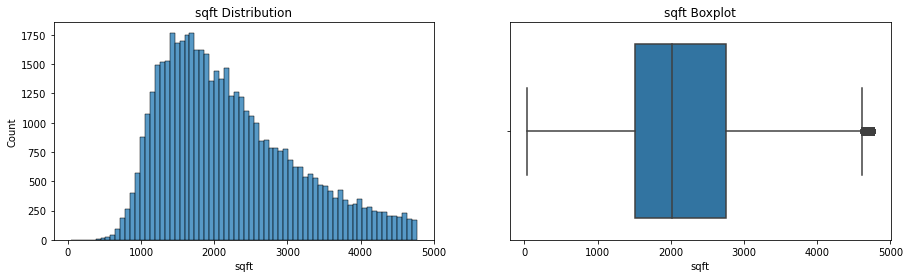

In [161]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=base_data, x='sqft', ax=axes[0]);
histplot.set_title('sqft Distribution');
boxplot = sns.boxplot(data=base_data, x='sqft', ax=axes[1]);
boxplot.set_title('sqft Boxplot');
experiment.log_figure(figure=plt) # залогируем графики

{'web': 'https://www.comet.com/api/image/download?imageId=1ff5570125d748b6bdb80ccec1147521&experimentKey=670276578e9e4311b1e01f3288ffcb79',
 'api': 'https://www.comet.com/api/rest/v1/image/get-image?imageId=1ff5570125d748b6bdb80ccec1147521&experimentKey=670276578e9e4311b1e01f3288ffcb79',
 'imageId': '1ff5570125d748b6bdb80ccec1147521'}

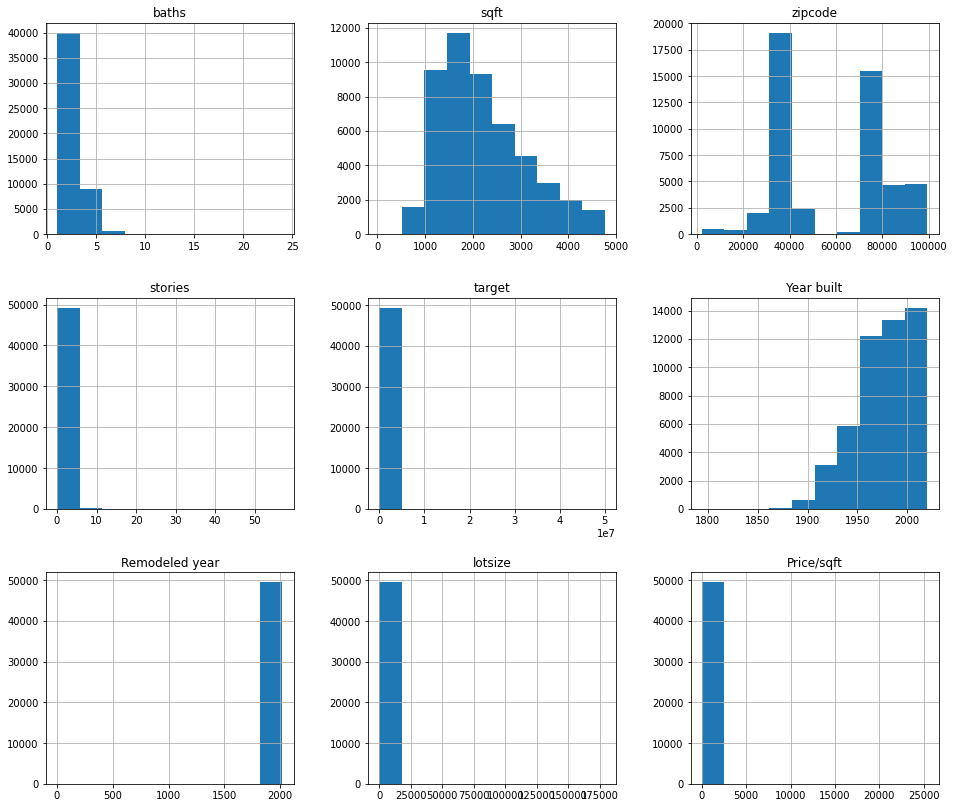

In [163]:
base_data.hist(figsize=(16,14));
experiment.log_figure(figure=plt) # залогируем графики

In [167]:
# удалим выбросы у всех остальных признаков
# # ['status', 'propertyType', 'baths', 'city', 'sqft', 'zipcode', 'state',
#        'stories', 'target', 'Year built', 'Remodeled year', 'Heating',
#        'Cooling', 'Parking', 'lotsize', 'Price/sqft']
outliers, base_data = outliers_iqr(base_data, 'lotsize')
print('lotsize')
print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print(f'Результирующее число записей: {base_data.shape[0]}')

outliers, base_data = outliers_iqr(base_data, 'baths')
print('\nbaths')
print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print(f'Результирующее число записей: {base_data.shape[0]}')

outliers, base_data = outliers_iqr(base_data, 'stories')
print('\nstories')
print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print(f'Результирующее число записей: {base_data.shape[0]}')

outliers, base_data = outliers_iqr(base_data, 'target')
print('\ntarget')
print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print(f'Результирующее число записей: {base_data.shape[0]}')

outliers, base_data = outliers_iqr(base_data, 'Price/sqft')
print('\nPrice/sqft')
print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print(f'Результирующее число записей: {base_data.shape[0]}')

outliers, base_data = outliers_iqr(base_data, 'Remodeled year')
print('\nRemodeled year')
print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print(f'Результирующее число записей: {base_data.shape[0]}')


lotsize
Число выбросов по методу Тьюки: 7
Результирующее число записей: 49492

baths
Число выбросов по методу Тьюки: 2725
Результирующее число записей: 46767

stories
Число выбросов по методу Тьюки: 514
Результирующее число записей: 46253

target
Число выбросов по методу Тьюки: 3364
Результирующее число записей: 42889

Price/sqft
Число выбросов по методу Тьюки: 2155
Результирующее число записей: 40734

Remodeled year
Число выбросов по методу Тьюки: 416
Результирующее число записей: 40318


{'web': 'https://www.comet.com/api/image/download?imageId=7d5d34248b864f0898f99393b391cde2&experimentKey=670276578e9e4311b1e01f3288ffcb79',
 'api': 'https://www.comet.com/api/rest/v1/image/get-image?imageId=7d5d34248b864f0898f99393b391cde2&experimentKey=670276578e9e4311b1e01f3288ffcb79',
 'imageId': '7d5d34248b864f0898f99393b391cde2'}

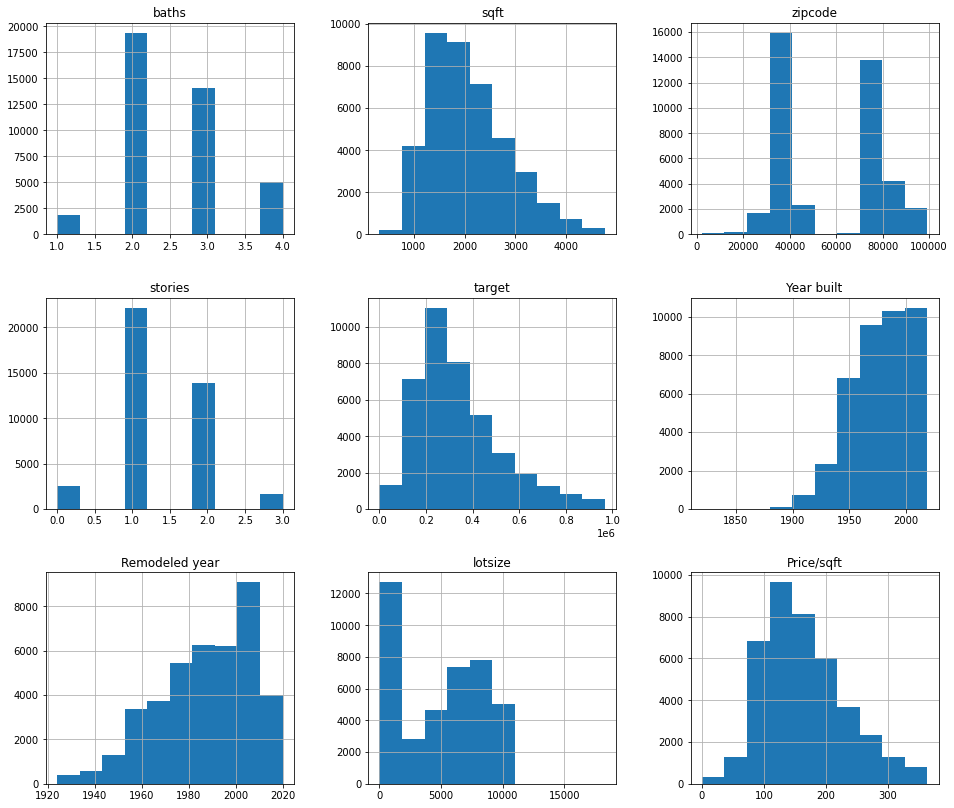

In [168]:
base_data.hist(figsize=(16,14));
experiment.log_figure(figure=plt) # залогируем графики

### Кодировка признаков

In [170]:
base_data.describe(include='object')

,status,propertyType,city,state,Heating,Cooling,Parking
count,40318,40318,40318,40318,40318,40318,40318
unique,5,9,492,22,47,31,115
top,for sale,single-family,Houston,FL,Forced Air,Central,Attached Garage
freq,30368,35524,6052,14369,18253,37076,18524


In [176]:
import category_encoders as ce

# для признаков с числом уникальных значений меньше 15 исопльзуем горячее кодирование
base_data_cod = pd.get_dummies(base_data, columns=['status','propertyType'])

# для других используем бинарное кодирование (кроме city и Parking)
bin_encoder = ce.BinaryEncoder(cols=['state','Heating','Cooling']) 
type_bin = bin_encoder.fit_transform(base_data_cod[['state','Heating','Cooling']])
base_data_cod = pd.concat([base_data_cod, type_bin], axis=1)

# отбираем 30 самых часто встречающихся значений признака city
cities = base_data['city'].value_counts().index
cities = cities[:30]

# отбираем 30 самых часто встречающихся значений признака Parking
park = base_data['Parking'].value_counts().index
park = park[:30]

# создаём новые признаки-маячки
for i in range(len(cities)):
    base_data_cod[cities[i]] = base_data_cod['city'].apply(lambda x: 1 if cities[i] in x else 0)
# создаём новые признаки-маячки = есть ли этот тег в списки тегов отзыва
for i in range(len(park)):
    base_data_cod[park[i]] = base_data_cod['Parking'].apply(lambda x: 1 if park[i] in x else 0)

### Удаление нечисловых значений

In [178]:
object_columns = [s for s in base_data_cod.columns if base_data_cod[s].dtypes == 'object']
base_data_cod.drop(object_columns, axis = 1, inplace=True)

# BASELINE Построение модели
Линейная регрессия

In [201]:
from sklearn import linear_model #линейные модели
from sklearn import metrics #метрики
from sklearn import preprocessing #предобработка
from sklearn.model_selection import train_test_split #разделение выборки

In [202]:
features = base_data_cod.drop('target', axis=1).columns
X, y = base_data_cod[features], base_data_cod['target']

#Создаем тренировочную и тестовую выборки с помощью train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, #таблица с наблюдениями и столбец с правильным ответами
    test_size=0.2, #размер тестовой выборки
    random_state=42 #число отвечающее за генерацию случайных чисел
)
#Выводим размеры полученных выборок
print('Train shape: {}'.format(X_train.shape))
print('Test shape: {}'.format(X_test.shape))

Train shape: (32254, 98)
Test shape: (8064, 98)


In [210]:
def print_metrics(y_train, y_train_predict, y_test, y_test_predict):
    metr = {"Train R^2": round(metrics.r2_score(y_train, y_train_predict),3),
            "Train MAE": round(metrics.mean_absolute_error(y_train, y_train_predict),3),
            "Train MAPE": round(metrics.mean_absolute_percentage_error(y_train, y_train_predict)*100,3),
            "Test R^2": round(metrics.r2_score(y_test, y_test_predict),3),
            "Test MAE": round(metrics.mean_absolute_error(y_test, y_test_predict),3),
            "Test MAPE": round(metrics.mean_absolute_percentage_error(y_test, y_test_predict)*100,3)}
    print(metr)
    return metr

In [211]:
lr = linear_model.LinearRegression()
lr.fit(X_train, y_train)
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)
# #Выводим результирующие метрики
metric = print_metrics(y_train, y_train_pred, y_test, y_test_pred)

{'Train R^2': 0.936, 'Train MAE': 31464.713, 'Train MAPE': 179.884, 'Test R^2': 0.932, 'Test MAE': 32122.884, 'Test MAPE': 14.239}


In [212]:
# логируем
random_state = 42
params={"random_state":random_state,
        "model_type":"lr"
}
experiment.log_parameters(params)
experiment.log_metrics(metric)


In [213]:
experiment.end()

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/masnikova-comet/final-project/670276578e9e4311b1e01f3288ffcb79
COMET INFO:   Metrics:
COMET INFO:     Test MAE   : 32122.884
COMET INFO:     Test MAPE  : 14.239
COMET INFO:     Test R^2   : 0.932
COMET INFO:     Train MAE  : 31464.713
COMET INFO:     Train MAPE : 179.884
COMET INFO:     Train R^2  : 0.936
COMET INFO:   Parameters:
COMET INFO:     copy_X        : True
COMET INFO:     fit_intercept : True
COMET INFO:     model_type    : lr
COMET INFO:     n_jobs        : 1
COMET INFO:     normalize     : deprecated
COMET INFO:     positive      : False
COMET INFO:     random_state  : 42
COMET INFO:   Uploads:
COMET INFO:     environment details      : 1
COMET INFO:     figures                  : 3
COMET INFO:     filename                 : 1
COMET 

### 2 эксперимент

In [96]:
# Create an experiment with your api key
experiment = Experiment(
    api_key="nhFiCphwBmDKmZBsi0LZLPe0C",
    project_name="final-project",
    workspace="masnikova-comet",
)

COMET WARNING: Comet has disabled auto-logging functionality as it has been imported after the following ML modules: sklearn. Metrics and hyperparameters can still be logged using comet_ml.log_metrics() and comet_ml.log_parameters()
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/masnikova-comet/final-project/dc92ad4d41a04858bed08acd5f6e00c1



Теперь заполним пропуски, какие возможно, и посмотрим на корреляцию признаков.

In [72]:
df_2 = drop_data.copy()
df_2 = df_2.drop(['schools_raiting','schools_distance','schools_grades','schools_name'],axis=1)

In [73]:
def zip(s):
    s = str(s)
    if s.count('-'):
        i=s.find('-')
        return s[:i]
    return s

df_2['zipcode'] = df_2['zipcode'].apply(zip)

In [65]:
df_2

,status,propertyType,street,baths,city,sqft,zipcode,beds,state,MlsId,target,Year built,Heating,Cooling,lotsize,Price/sqft
0,active,single-family,240 Heather Ln,3,Southern Pines,2900,28387,4,NC,611019,418000,2019,"Central A/C, Heat Pump",NaN,NaN,144
1,for sale,single-family,12911 E Heroy Ave,3,Spokane Valley,1947,99216,3,WA,201916904,310000,2019,NaN,NaN,5828,159
2,for sale,single-family,2005 Westridge Rd,2,Los Angeles,3000,90049,3,CA,FR19221027,2895000,1961,Forced Air,Central,8626,965
3,for sale,single-family,4311 Livingston Ave,8,Dallas,6457,75205,5,TX,14191809,2395000,2006,Forced Air,Central,8220,371
4,for sale,land,1524 Kiscoe St,NaN,Palm Bay,NaN,32908,NaN,FL,861745,5000,NaN,NaN,NaN,10019,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
377180,nan,single-family,20800 NE 23rd Ave,6,Miami,4017,33180,5,FL,A10702700,1249000,1990,Other,Central,8500,311
377181,for sale,condo,3530 N Lake Shore Dr #4B,3,Chicago,2000,60657,3,IL,10374233,674999,1924,Radiant,NaN,NaN,337
377182,for sale,single-family,15509 Linden Blvd,3,Jamaica,1152,11434,3,NY,NaN,528000,1950,Other,NaN,1600,458
377183,nan,unknown,7810 Pereida St,NaN,Houston,NaN,77028,NaN,TX,NaN,34500,None,None,None,NaN,NaN


In [74]:
# меняем тип на числовой у признаков, для которых это возможно
df_2['baths'] = df_2['baths'].apply(pd.to_numeric)
df_2['beds'] = df_2['beds'].apply(pd.to_numeric)
df_2['sqft'] = df_2['sqft'].apply(pd.to_numeric)
df_2['target'] = df_2['target'].apply(pd.to_numeric)
df_2['Year built'] = df_2['Year built'].apply(pd.to_numeric)
df_2['lotsize'] = df_2['lotsize'].apply(pd.to_numeric)
df_2['Price/sqft'] = df_2['Price/sqft'].apply(pd.to_numeric)
df_2['zipcode'] = df_2['zipcode'].apply(pd.to_numeric)

In [75]:
df_2.head(2)

,status,propertyType,street,baths,city,sqft,zipcode,beds,state,MlsId,target,Year built,Heating,Cooling,lotsize,Price/sqft
0,active,single-family,240 Heather Ln,3.0,Southern Pines,2900.0,28387.0,4.0,NC,611019,418000.0,2019.0,"Central A/C, Heat Pump",NaN,NaN,144.0
1,for sale,single-family,12911 E Heroy Ave,3.0,Spokane Valley,1947.0,99216.0,3.0,WA,201916904,310000.0,2019.0,NaN,NaN,5828.0,159.0


In [77]:
# заполняем пропуски
#создаем словарь имя столбца: число(признак) на который надо заменить пропуски
values = {
    'baths': df_2['baths'].median(),
    'sqft': df_2['sqft'].median(),
    'beds': df_2['beds'].median(),
    'target': df_2['target'].median(),
    'Year built': df_2['Year built'].median(),
    'lotsize': df_2['lotsize'].median(),
    'Price/sqft': df_2['Price/sqft'].median(),
    'zipcode': df_2['zipcode'].median(),
    'street': df_2['street'].mode()[0],
    'city': df_2['city'].mode()[0],
    'Heating': df_2['Heating'].mode()[0],
    'Cooling': df_2['Cooling'].mode()[0],
    'zipcode': df_2['zipcode'].mode()[0]
}
#заполняем пропуски в соответствии с заявленным словарем
df_2 = df_2.fillna(values)
#выводим результирующую долю пропусков
df_2.isnull().mean()

status          0.000000
propertyType    0.000000
street          0.000000
baths           0.000000
city            0.000000
sqft            0.000000
zipcode         0.000000
beds            0.000000
state           0.000000
MlsId           0.177314
target          0.000000
Year built      0.000000
Heating         0.000000
Cooling         0.000000
lotsize         0.000000
Price/sqft      0.000000
dtype: float64

In [78]:
# удаляем слишком уникальный столбец MlsId'
df_2 = df_2.drop('MlsId',axis=1)

### Дубликаты

In [79]:
# проверяем на дубликаты
print(f'Число найденных дубликатов: {sum(df_2.duplicated())}')
# удаляем дубликаты
df_2 = df_2.drop_duplicates()
df_2.shape

Число найденных дубликатов: 835


(376350, 15)

### Выбросы

In [85]:
df_2['baths'] = df_2['baths'].astype(int)
df_2['sqft'] = df_2['sqft'].astype(int)
df_2['zipcode'] = df_2['zipcode'].astype(int)
df_2['beds'] = df_2['beds'].astype(int)
df_2['target'] = df_2['target'].astype(int)
df_2['Year built'] = df_2['Year built'].astype(int)
df_2['lotsize'] = df_2['lotsize'].astype(int)
df_2['Price/sqft'] = df_2['Price/sqft'].astype(int)

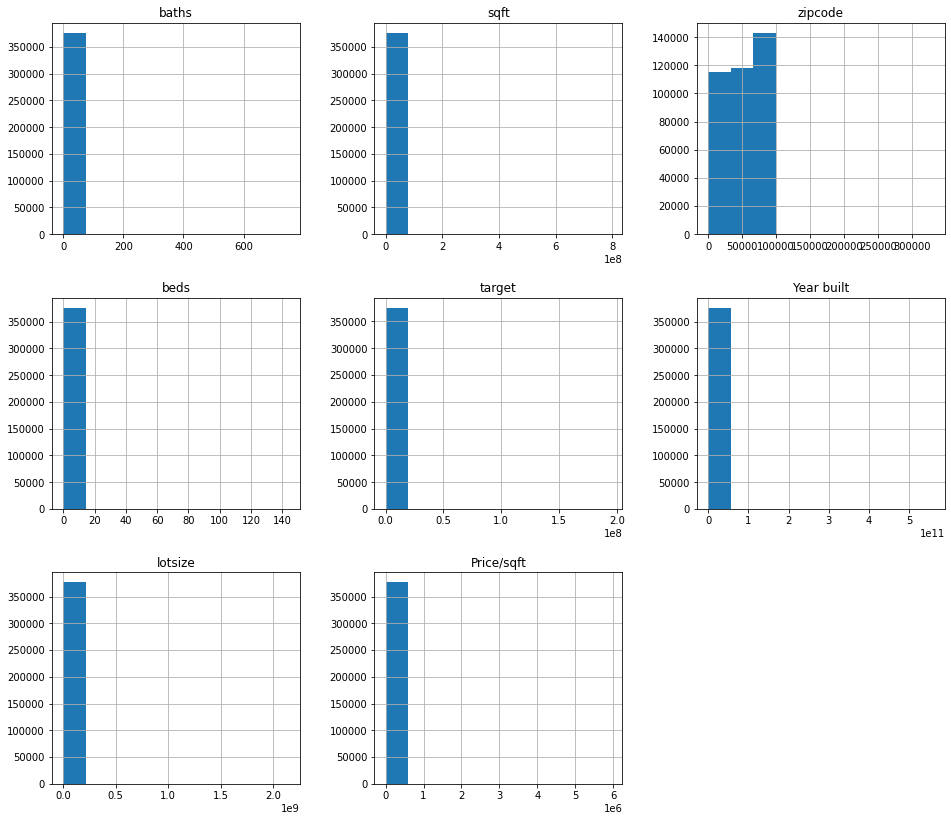

In [86]:
# посмотрим на распределения
df_2.hist(figsize=(16,14));
#experiment.log_figure(figure=plt) # залогируем графики

In [92]:
# удалим выбросы по методу Тьюки
# # ['status', 'propertyType', 'baths', 'city', 'sqft', 'zipcode', 'state',
#        'stories', 'target', 'Year built', 'Remodeled year', 'Heating',
#        'Cooling', 'Parking', 'lotsize', 'Price/sqft']
outliers, df_2 = outliers_iqr(df_2, 'lotsize')
print('lotsize')
print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print(f'Результирующее число записей: {df_2.shape[0]}')

outliers, df_2 = outliers_iqr(df_2, 'baths')
print('\nbaths')
print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print(f'Результирующее число записей: {df_2.shape[0]}')

outliers, df_2 = outliers_iqr(df_2, 'beds')
print('\nstories')
print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print(f'Результирующее число записей: {df_2.shape[0]}')

outliers, df_2 = outliers_iqr(df_2, 'target')
print('\ntarget')
print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print(f'Результирующее число записей: {df_2.shape[0]}')

outliers, df_2 = outliers_iqr(df_2, 'Price/sqft')
print('\nPrice/sqft')
print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print(f'Результирующее число записей: {df_2.shape[0]}')

outliers, df_2 = outliers_iqr(df_2, 'sqft')
print('\nsqft')
print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print(f'Результирующее число записей: {df_2.shape[0]}')

outliers, df_2 = outliers_iqr(df_2, 'Year built')
print('\nYear built')
print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print(f'Результирующее число записей: {df_2.shape[0]}')

lotsize
Число выбросов по методу Тьюки: 17998
Результирующее число записей: 358352

baths
Число выбросов по методу Тьюки: 21236
Результирующее число записей: 337116

stories
Число выбросов по методу Тьюки: 128019
Результирующее число записей: 209097

target
Число выбросов по методу Тьюки: 19625
Результирующее число записей: 189472

Price/sqft
Число выбросов по методу Тьюки: 20271
Результирующее число записей: 169201

sqft
Число выбросов по методу Тьюки: 12303
Результирующее число записей: 156898

Year built
Число выбросов по методу Тьюки: 2154
Результирующее число записей: 154744


{'web': 'https://www.comet.com/api/image/download?imageId=87224c6f12d84974bb9d89695c8857f6&experimentKey=dc92ad4d41a04858bed08acd5f6e00c1',
 'api': 'https://www.comet.com/api/rest/v1/image/get-image?imageId=87224c6f12d84974bb9d89695c8857f6&experimentKey=dc92ad4d41a04858bed08acd5f6e00c1',
 'imageId': '87224c6f12d84974bb9d89695c8857f6'}

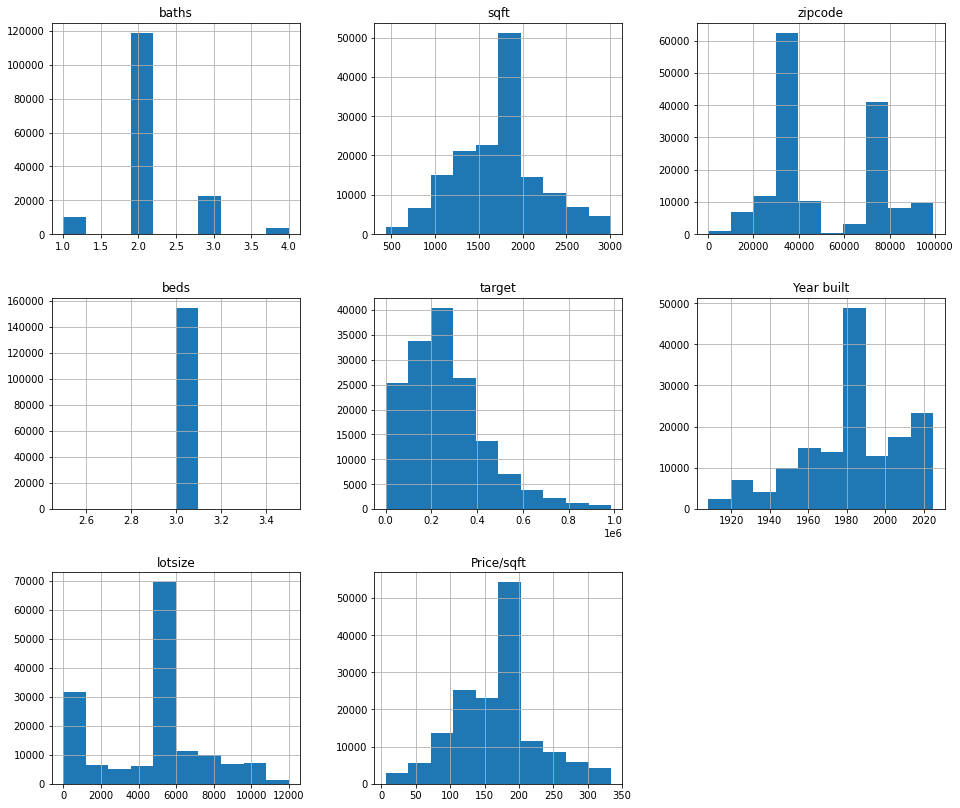

In [97]:
df_2.hist(figsize=(16,14));
experiment.log_figure(figure=plt) # залогируем графики

{'web': 'https://www.comet.com/api/image/download?imageId=435eacdb795a4b23b93c784fc02fe88f&experimentKey=dc92ad4d41a04858bed08acd5f6e00c1',
 'api': 'https://www.comet.com/api/rest/v1/image/get-image?imageId=435eacdb795a4b23b93c784fc02fe88f&experimentKey=dc92ad4d41a04858bed08acd5f6e00c1',
 'imageId': '435eacdb795a4b23b93c784fc02fe88f'}

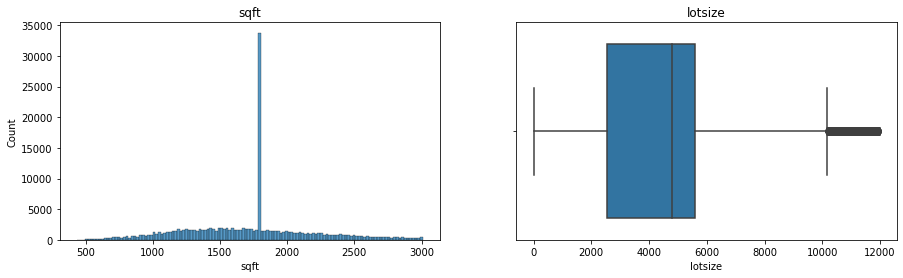

In [98]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=df_2, x='sqft', ax=axes[0]);
histplot.set_title('sqft');
boxplot = sns.boxplot(data=df_2, x='lotsize', ax=axes[1]);
boxplot.set_title('lotsize');
experiment.log_figure(figure=plt) # залогируем графики

In [99]:
# сохраним очищенный датасет
df_2.to_csv('data/df_clean.csv',index=True)

### Кодировка признаков

In [100]:
df_2.describe(include='object')

,status,propertyType,street,city,state,Heating,Cooling
count,154744,154744,154744,154744,154744,154744,154744
unique,75,78,141305,1482,35,816,736
top,for sale,single-family,Undisclosed Address,Houston,FL,Forced Air,Central
freq,72724,73243,384,13737,50453,80777,108648


In [101]:
# в столбце street слишком много уникальных значений. В этом эксперименте удалим его
df_2 = df_2.drop('street', axis=1)

In [103]:
import category_encoders as ce

# для status, propertyType, state используем бинарное кодирование 
bin_encoder = ce.BinaryEncoder(cols=['state','propertyType','status']) 
type_bin = bin_encoder.fit_transform(df_2[['state','propertyType','status']])
df_2_cod = pd.concat([df_2, type_bin], axis=1)

# отбираем 30 самых часто встречающихся значений признака city
cities = df_2['city'].value_counts().index
cities = cities[:30]

# отбираем 30 самых часто встречающихся значений признака Heating
heat = df_2['Heating'].value_counts().index
heat = heat[:30]

# отбираем 30 самых часто встречающихся значений признака Cooling
cool = df_2['Cooling'].value_counts().index
cool = cool[:30]

# создаём новые признаки-маячки
for i in range(len(cities)):
    df_2_cod[cities[i]] = df_2_cod['city'].apply(lambda x: 1 if cities[i] in x else 0)
# создаём новые признаки-маячки
for i in range(len(heat)):
    df_2_cod[heat[i]] = df_2_cod['Heating'].apply(lambda x: 1 if heat[i] in x else 0)
for i in range(len(cool)):
    df_2_cod[cool[i]] = df_2_cod['Cooling'].apply(lambda x: 1 if cool[i] in x else 0)

### Удаление нечисловых значений

In [104]:
object_columns = [s for s in df_2_cod.columns if df_2_cod[s].dtypes == 'object']
df_2_cod.drop(object_columns, axis = 1, inplace=True)

## Отбор признаков

#### Корреляция

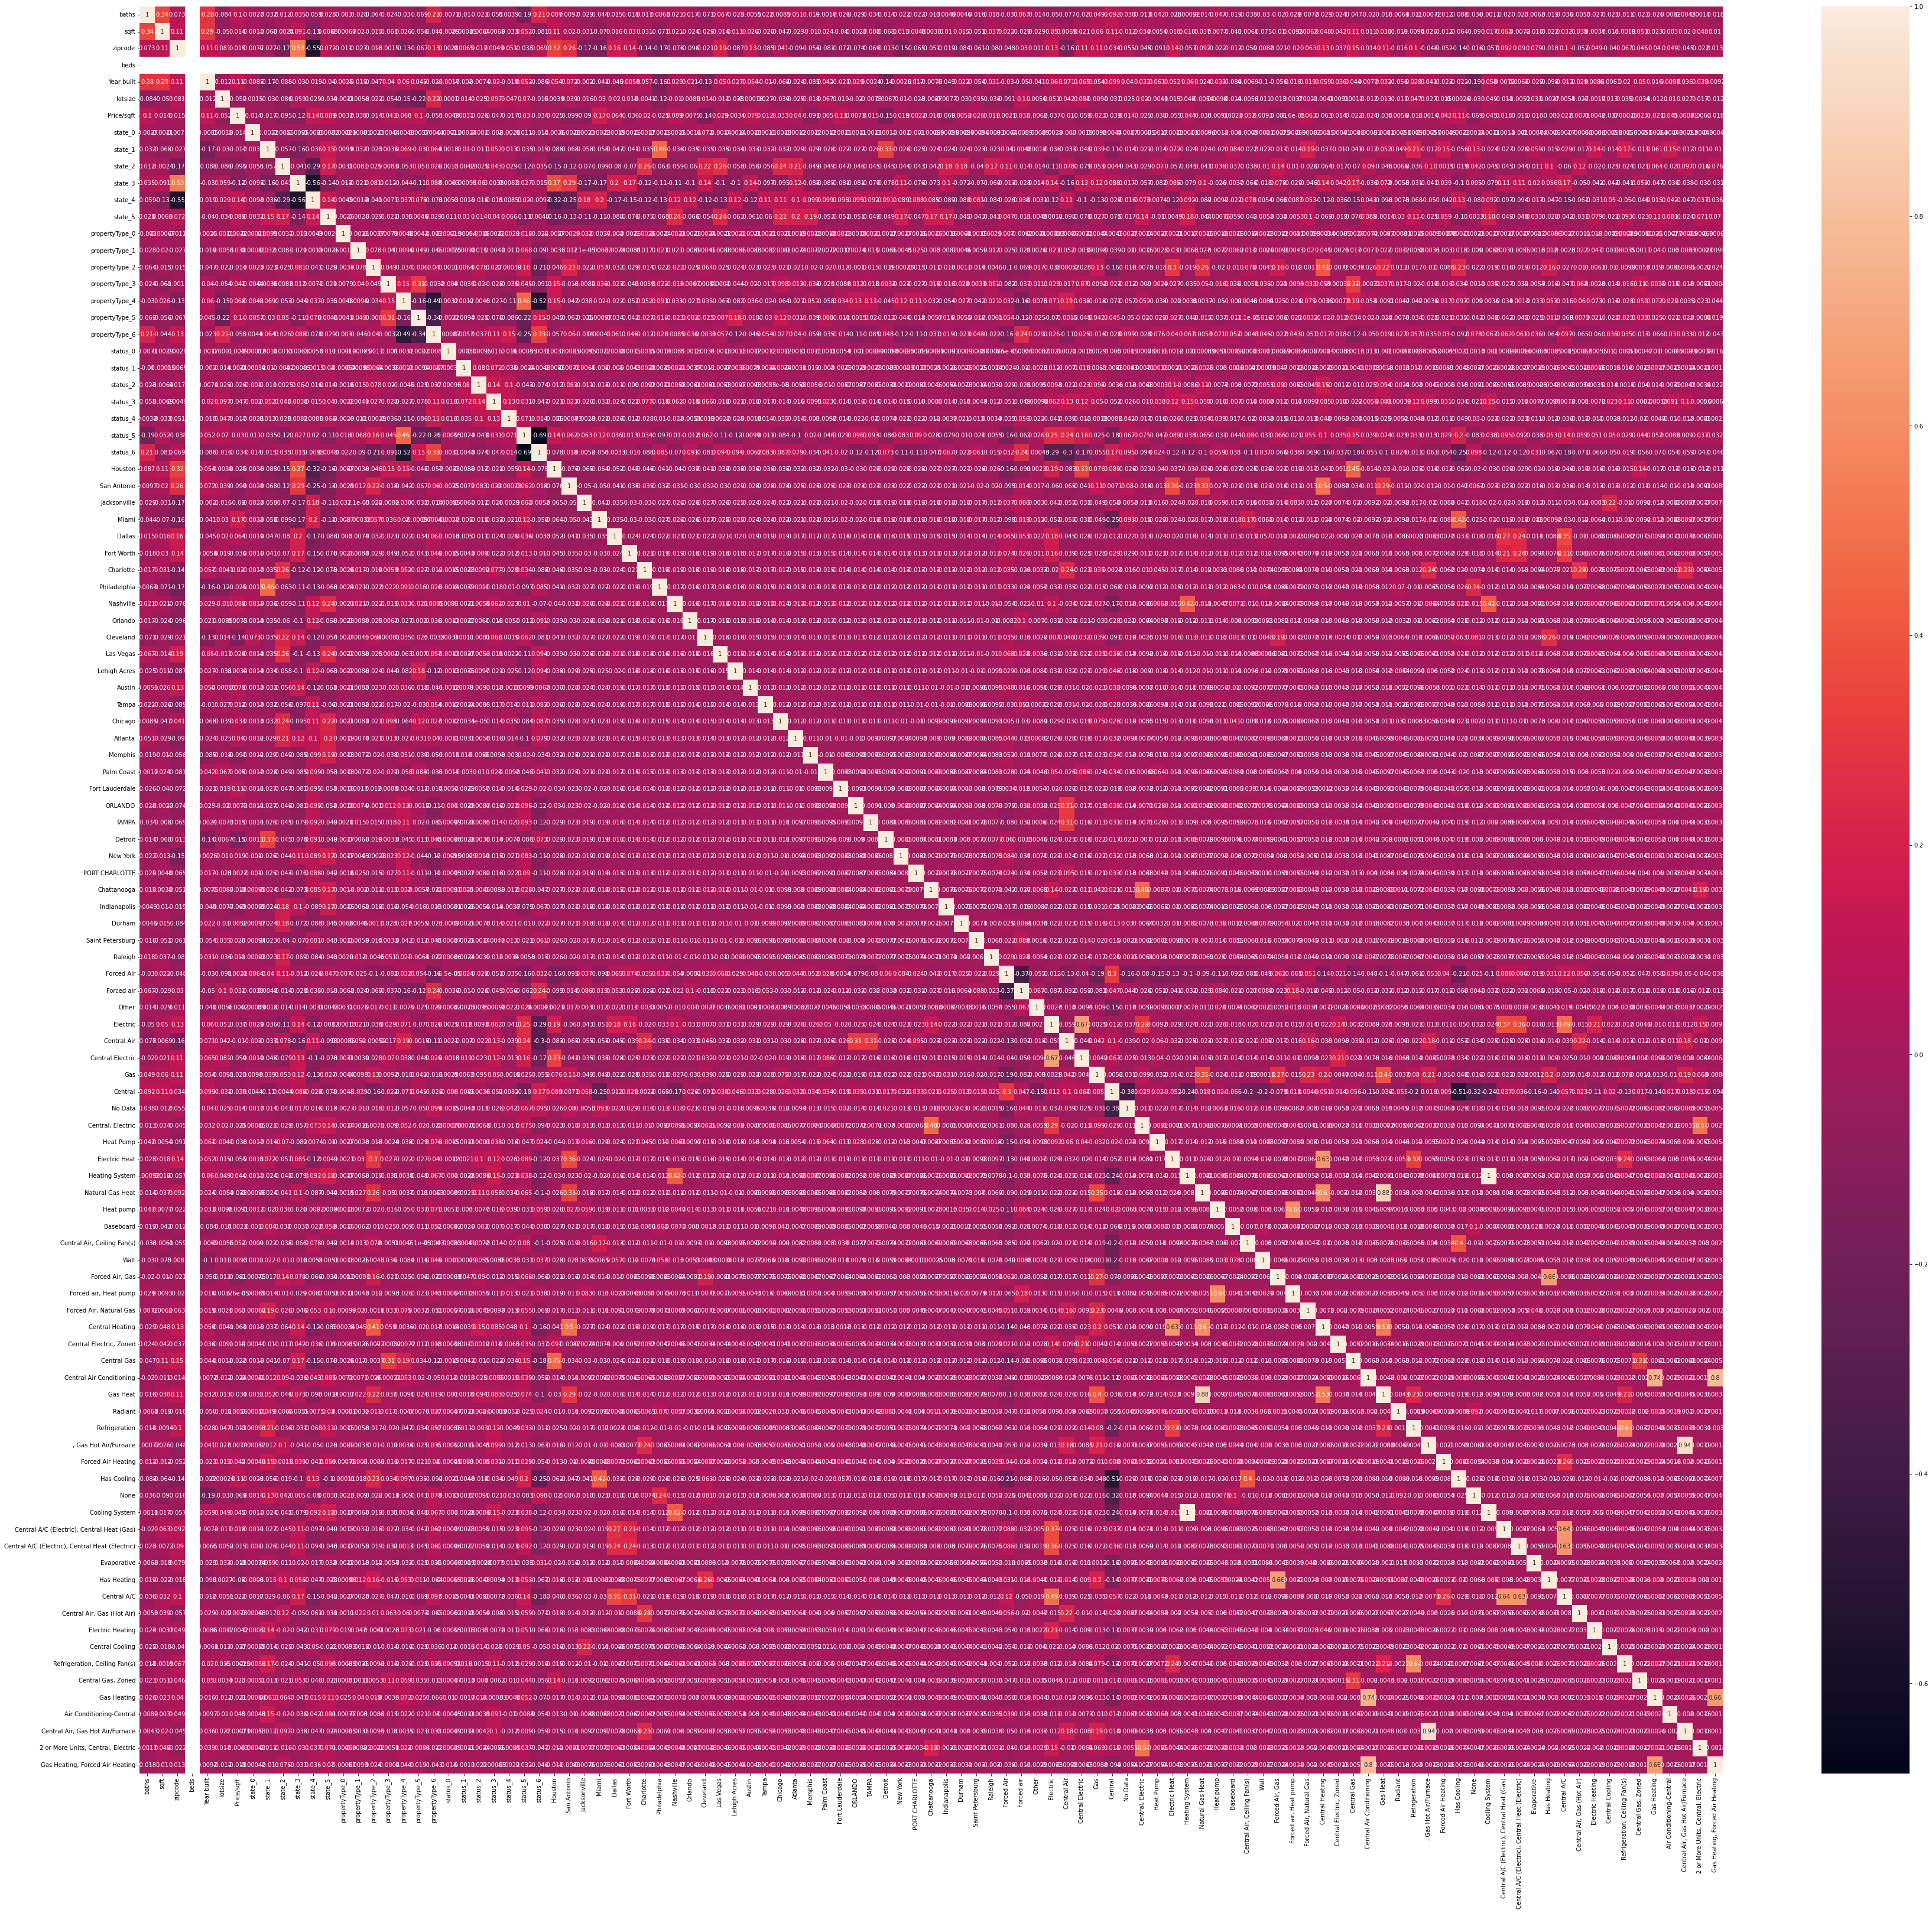

In [108]:
plt.rcParams['figure.figsize'] = (60, 55)
sns.heatmap(df_2_cod.drop(['target'], axis=1).corr(), annot=True);

## Построение модели. Версия 2
Линейная регрессия

In [115]:
features = df_2_cod.drop('target', axis=1).columns
X, y = df_2_cod[features], df_2_cod['target']

#Создаем тренировочную и тестовую выборки с помощью train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, #таблица с наблюдениями и столбец с правильным ответами
    test_size=0.2, #размер тестовой выборки
    random_state=42 #число отвечающее за генерацию случайных чисел
)
#Выводим размеры полученных выборок
print('Train shape: {}'.format(X_train.shape))
print('Test shape: {}'.format(X_test.shape))

Train shape: (123795, 105)
Test shape: (30949, 105)


In [116]:
lr = linear_model.LinearRegression()
lr.fit(X_train, y_train)
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)
# #Выводим результирующие метрики
metric = print_metrics(y_train, y_train_pred, y_test, y_test_pred)

{'Train R^2': 0.625, 'Train MAE': 63602.277, 'Train MAPE': 797.407, 'Test R^2': 0.626, 'Test MAE': 63268.019, 'Test MAPE': 1660.302}


В baseline у нас были метрики:  
{'Train R^2': 0.936, 'Train MAE': 31464.713, 'Train MAPE': 179.884, 'Test R^2': 0.932, 'Test MAE': 32122.884, 'Test MAPE': 14.239}

  
Видно, что на тестовых данных метрики сильно улучшились. Абсолютная ошибка стала почти в 2 раза меньше.


In [117]:
# логируем
random_state = 42
params={"random_state":random_state,
        "model_type":"lr"
}
experiment.log_parameters(params)
experiment.log_metrics(metric)
experiment.end()

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/masnikova-comet/final-project/dc92ad4d41a04858bed08acd5f6e00c1
COMET INFO:   Metrics:
COMET INFO:     Test MAE   : 63268.019
COMET INFO:     Test MAPE  : 1660.302
COMET INFO:     Test R^2   : 0.626
COMET INFO:     Train MAE  : 63602.277
COMET INFO:     Train MAPE : 797.407
COMET INFO:     Train R^2  : 0.625
COMET INFO:   Parameters:
COMET INFO:     copy_X        : True
COMET INFO:     fit_intercept : True
COMET INFO:     model_type    : lr
COMET INFO:     n_jobs        : 1
COMET INFO:     normalize     : deprecated
COMET INFO:     positive      : False
COMET INFO:     random_state  : 42
COMET INFO:   Uploads:
COMET INFO:     environment details      : 1
COMET INFO:     figures                  : 2
COMET INFO:     filename                 : 1
COME

# 3 эксперимент